```
---
title: Enrichment analysis of proteins based on their GeneOntology annotations
tags: GeneOntology, UniProt, enrichmentAnalysis, SPARQL
lang: en
version: 0.9
date: 2024-03-28
---
```

In [1]:
import graphviz
import gzip
#import importlib
import IPython
#import json
import math
#import matplotlib.pyplot as plt
#import networkx as nx
#import os
import pandas as pd
#import rdflib
#import rdflib.namespace
import scipy.stats as stats
#import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sparqldataframe
#import sys

In [2]:
goaEndpointURL = "http://localhost:3030/goa/query"
#goEndpointURL = "http://localhost:3030/go/query"
uniprotEndpointURL = "http://sparql.uniprot.org/sparql/"
rdfFormat = "turtle"

taxon = {"id":"9606", "name":"human"}

#uniprotEndpointURLupdate = uniprotEndpointURL.replace("/query", "/update")
#goEndpointURLupdate = goEndpointURL.replace("/query", "/update")

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>


PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>
PREFIX up:<http://purl.uniprot.org/core/>

PREFIX go: <http://purl.obolibrary.org/obo/GO_>
PREFIX goavoc: <http://bio2rdf.org/goa_vocabulary:>

"""

In [4]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    print("Nb results: " + str(len(results["results"]["bindings"])))
    print()
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

In [5]:
# float_format example: float_format='{:,.2f}'.format
def full_display(x, max_rows=None, max_columns=None, max_colwidth=None, width=2000, float_format=None):
    '''
    Displays a pandas dataframe.
    '''
    with pd.option_context('display.max_rows', max_rows,
                           'display.max_columns', max_columns,
                           'display.max_colwidth', max_colwidth,
                           'display.width', width,
                           'display.float_format', float_format):
        display(x) 

# 1. Setup your environment

## 1.1 Datasets

**TODO:**
- Gene Ontology: retrieve `go.owl` from https://purl.obolibrary.org/obo/go.owl (use `wget https://purl.obolibrary.org/obo/go.owl` from the command line)
- GOA annotations (https://gitlab.com/odameron/goa2rdf)
- (optional) ECO Evidence and Conclusion Ontology: retrieve `eco.owl` from https://raw.githubusercontent.com/evidenceontology/evidenceontology/master/eco.owl (use `wget https://raw.githubusercontent.com/evidenceontology/evidenceontology/master/eco.owl` from the command line) 

![GOA SPARQL endpoint schema](figures/goa.png)

## 1.2 SPARQL endpoint

**TODO:**
- Apache fuseki installation https://gitlab.com/odameron/fusekiInstallationUsage

> ```bash
> ${FUSEKI_HOME}/fuseki-server --file ontologies/goa_human.gaf.ttl --file ontologies/go-latest.owl --file ontologies/evidenceCode.owl /goa
> ```

## 1.3 Metrics

Based on:
- GeneOntology 2023-11-15
- GOA 2023-11-15

In [6]:
query = """
SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:""" + taxon["id"] + """ .
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print("Nb human proteins: " + results["results"]["bindings"][0]["nbProteins"]["value"])

Nb human proteins: 19670


In [7]:
query = """
SELECT (COUNT(DISTINCT ?goIdent) AS ?nbGOterms)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
print("Nb GO terms: " + results["results"]["bindings"][0]["nbGOterms"]["value"])

Nb GO terms: 42803


In [8]:
query = """
SELECT ?goRoot ?goLabel (COUNT(DISTINCT ?goIdent) AS ?nbDescendants)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goRoot ?goLabel
ORDER BY DESC(?nbDescendants)
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
for result in results["results"]["bindings"]:
    print(result["goRoot"]["value"] + "\t" + result["goLabel"]["value"] + "\t" + result["nbDescendants"]["value"])

http://purl.obolibrary.org/obo/GO_0008150	biological_process	27790
http://purl.obolibrary.org/obo/GO_0003674	molecular_function	11235
http://purl.obolibrary.org/obo/GO_0005575	cellular_component	4061


In [9]:
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot             goLabel nbDescendants
0  http://purl.obolibrary.org/obo/GO_0008150  biological_process         27790
1  http://purl.obolibrary.org/obo/GO_0003674  molecular_function         11235
2  http://purl.obolibrary.org/obo/GO_0005575  cellular_component          4061

**Gene Ontology 2023-11-15:**

| goId | goLabel | nb desc. |
|:---|:---|---:|
| go:0008150 | biological process | 27,790 |
| go:0003674 | molecular function | 11,235 |
| go:0005575 | cellular component | 4,061 |
|  |  | **43,086**|

**FIXME:** 42,870 lines in `results/GeneOntology_label.tsv`. Some GO terms belong to multiple branches and/or do not have label?

In [13]:
query = """
SELECT ?goRoot ?goLabel (COUNT(DISTINCT ?goIdent) AS ?nbDescendants)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goRoot ?goLabel
ORDER BY DESC(?nbDescendants)
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot             goLabel nbDescendants
0  http://purl.obolibrary.org/obo/GO_0008150  biological_process         27790
1  http://purl.obolibrary.org/obo/GO_0003674  molecular_function         11235
2  http://purl.obolibrary.org/obo/GO_0005575  cellular_component          4061

> **Interpretation:** 
> all the GO terms have a label

In [16]:
query = """
SELECT ?goRoot1 ?goLabel1 ?goRoot2 ?goLabel2 (COUNT(DISTINCT ?goIdent) AS ?nbDescendants)
WHERE {
  VALUES ?goRoot1 { go:0005575 go:0003674 }
  VALUES ?goRoot2 { go:0008150 go:0005575 }
  FILTER (str(?goRoot1) < str(?goRoot2))
  ?goRoot1 rdfs:label ?goLabel1 .
  ?goRoot2 rdfs:label ?goLabel2 .
  ?goIdent rdfs:subClassOf* ?goRoot1 .
  ?goIdent rdfs:subClassOf* ?goRoot2 .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goRoot1 ?goLabel1 ?goRoot2 ?goLabel2
ORDER BY DESC(?nbDescendants)
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot1            goLabel1  \
0  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   

                                     goRoot2            goLabel2 nbDescendants  
0  http://purl.obolibrary.org/obo/GO_0008150  biological_process           283

In [17]:
query = """
SELECT ?goRoot1 ?goLabel1 ?goRoot2 ?goLabel2 ?goIdent ?goIdentLabel
WHERE {
  VALUES ?goRoot1 { go:0005575 go:0003674 }
  VALUES ?goRoot2 { go:0008150 go:0005575 }
  FILTER (str(?goRoot1) < str(?goRoot2))
  ?goRoot1 rdfs:label ?goLabel1 .
  ?goRoot2 rdfs:label ?goLabel2 .
  ?goIdent rdfs:subClassOf* ?goRoot1 .
  ?goIdent rdfs:subClassOf* ?goRoot2 .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goRoot1            goLabel1  \
0    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
1    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
2    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
3    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
4    http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
..                                         ...                 ...   
279  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
280  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
281  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
282  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   
283  http://purl.obolibrary.org/obo/GO_0003674  molecular_function   

                                       goRoot2            goLabel2  \
0    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
1    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
2    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
3    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
4    http://purl.obolibrary.org/obo/GO_0008150  biological_process   
..                                         ...                 ...   
279  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
280  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
281  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
282  http://purl.obolibrary.org/obo/GO_0008150  biological_process   
283  http://purl.obolibrary.org/obo/GO_0008150  biological_process   

                                       goIdent  \
0    http://purl.obolibrary.org/obo/GO_0005254   
1    http://purl.obolibrary.org/obo/GO_0061797   
2    http://purl.obolibrary.org/obo/GO_0072320   
3    http://purl.obolibrary.org/obo/GO_0008068   
4    http://purl.obolibrary.org/obo/GO_0061778   
..                                         ...   
279  http://purl.obolibrary.org/obo/GO_0043398   
280  http://purl.obolibrary.org/obo/GO_0097162   
281  http://purl.obolibrary.org/obo/GO_0035877   
282  http://purl.obolibrary.org/obo/GO_0035501   
283  http://purl.obolibrary.org/obo/GO_0101016   

                                          goIdentLabel  
0                            chloride channel activity  
1                   pH-gated chloride channel activity  
2           volume-sensitive chloride channel activity  
3    extracellularly glutamate-gated chloride chann...  
4              intracellular chloride channel activity  
..                                                 ...  
279                                 HLH domain binding  
280                            MADS box domain binding  
281                      death effector domain binding  
282                                 MH1 domain binding  
283                         FMN-binding domain binding  

[284 rows x 6 columns]

![Ancestors of go:0005254 chloride channel activity](figures/go_hierarchy_0005254_chloride_channel_activity.png)

> **Control:** 43,086-283=42,803
>
> yet, 42,870 lines in `results/GeneOntology_label.tsv`.
> Some GO terms have multiple labels?

In [22]:
query = """
SELECT ?goIdent (COUNT(DISTINCT ?goIdentLabel) AS ?nbLabels)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goIdent
HAVING (COUNT(DISTINCT ?goIdentLabel) > 1)
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent nbLabels
0   http://purl.obolibrary.org/obo/GO_0005216        2
1   http://purl.obolibrary.org/obo/GO_0015075        2
2   http://purl.obolibrary.org/obo/GO_0043603        2
3   http://purl.obolibrary.org/obo/GO_0040033        2
4   http://purl.obolibrary.org/obo/GO_0040030        2
..                                        ...      ...
62  http://purl.obolibrary.org/obo/GO_0016441        2
63  http://purl.obolibrary.org/obo/GO_0060548        2
64  http://purl.obolibrary.org/obo/GO_0051270        2
65  http://purl.obolibrary.org/obo/GO_0051272        2
66  http://purl.obolibrary.org/obo/GO_0051271        2

[67 rows x 2 columns]

In [21]:
query = """
SELECT DISTINCT ?goIdent ?goIdentLabel ?goIdentLabel2
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  ?goIdent rdfs:label ?goIdentLabel2 .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER (?goIdentLabel != ?goIdentLabel2)
}
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent  \
0    http://purl.obolibrary.org/obo/GO_0006811   
1    http://purl.obolibrary.org/obo/GO_0006811   
2    http://purl.obolibrary.org/obo/GO_0006820   
3    http://purl.obolibrary.org/obo/GO_0006820   
4    http://purl.obolibrary.org/obo/GO_0034220   
..                                         ...   
129  http://purl.obolibrary.org/obo/GO_0015075   
130  http://purl.obolibrary.org/obo/GO_0004520   
131  http://purl.obolibrary.org/obo/GO_0004520   
132  http://purl.obolibrary.org/obo/GO_0004536   
133  http://purl.obolibrary.org/obo/GO_0004536   

                                          goIdentLabel  \
0                                        ion transport   
1                             monoatomic ion transport   
2                                      anion transport   
3                           monoatomic anion transport   
4                          ion transmembrane transport   
..                                                 ...   
129  monoatomic ion transmembrane transporter activity   
130                          DNA endonuclease activity   
131                     endodeoxyribonuclease activity   
132                              DNA nuclease activity   
133                         deoxyribonuclease activity   

                              goIdentLabel2  
0                  monoatomic ion transport  
1                             ion transport  
2                monoatomic anion transport  
3                           anion transport  
4    monoatomic ion transmembrane transport  
..                                      ...  
129  ion transmembrane transporter activity  
130          endodeoxyribonuclease activity  
131               DNA endonuclease activity  
132              deoxyribonuclease activity  
133                   DNA nuclease activity  

[134 rows x 3 columns]

> **Control:** 43,086-283=42,803
>
> yet, 42,870 lines in `results/GeneOntology_label.tsv`.
> 42,870-67=42,803

> **Synthesis:** 42,803 distinct GO terms, 67 of which have multiple labels, and 283 of which belong to multiple branches

In [40]:
query = """
SELECT DISTINCT ?goIdent ?goIdentLabel
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent  \
0      http://purl.obolibrary.org/obo/GO_0008150   
1      http://purl.obolibrary.org/obo/GO_0051179   
2      http://purl.obolibrary.org/obo/GO_0031503   
3      http://purl.obolibrary.org/obo/GO_0034630   
4      http://purl.obolibrary.org/obo/GO_1990953   
...                                          ...   
42865  http://purl.obolibrary.org/obo/GO_0030281   
42866  http://purl.obolibrary.org/obo/GO_0140223   
42867  http://purl.obolibrary.org/obo/GO_0001181   
42868  http://purl.obolibrary.org/obo/GO_0016251   
42869  http://purl.obolibrary.org/obo/GO_0000995   

                                            goIdentLabel  
0                                     biological_process  
1                                           localization  
2                protein-containing complex localization  
3                              RITS complex localization  
4                               intramanchette transport  
...                                                  ...  
42865      structural constituent of cutaneous appendage  
42866   general transcription initiation factor activity  
42867  RNA polymerase I general transcription initiat...  
42868  RNA polymerase II general transcription initia...  
42869  RNA polymerase III general transcription initi...  

[42870 rows x 2 columns]

In [44]:
query = """
SELECT DISTINCT ?goIdent (SAMPLE(?goIdentLabel) AS ?gLabel)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goIdent
"""
df = sparqldataframe.query(goaEndpointURL, prefixes+query)
df

goIdent  \
0      http://purl.obolibrary.org/obo/GO_1903186   
1      http://purl.obolibrary.org/obo/GO_0045160   
2      http://purl.obolibrary.org/obo/GO_1905581   
3      http://purl.obolibrary.org/obo/GO_0015047   
4      http://purl.obolibrary.org/obo/GO_0061953   
...                                          ...   
42798  http://purl.obolibrary.org/obo/GO_0005687   
42799  http://purl.obolibrary.org/obo/GO_0042887   
42800  http://purl.obolibrary.org/obo/GO_0050074   
42801  http://purl.obolibrary.org/obo/GO_0001727   
42802  http://purl.obolibrary.org/obo/GO_0102089   

                                                  gLabel  
0                           regulation of vitellogenesis  
1                                       myosin I complex  
2      positive regulation of low-density lipoprotein...  
3                 NADPH-cytochrome-c2 reductase activity  
4          mRNA (adenine-N1-)-methyltransferase activity  
...                                                  ...  
42798                                           U4 snRNP  
42799           amide transmembrane transporter activity  
42800                         malate-CoA ligase activity  
42801                              lipid kinase activity  
42802                dehydroscoulerine synthase activity  

[42803 rows x 2 columns]

## 1.4 Proportions of proteins and GO terms involved in annotations

In [7]:
query = """
SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:""" + taxon["id"] + """ .
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbproteins = results["results"]["bindings"][0]["nbProteins"]["value"]
print("Nb human proteins: " + totalNbproteins)

Nb human proteins: 19635


In [8]:
query = """
SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:""" + taxon["id"] + """ .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbproteinsAnnotated = results["results"]["bindings"][0]["nbProteins"]["value"]
print("Nb human proteins annotated by >=1 GO term: " + totalNbproteinsAnnotated)

Nb human proteins annotated by >=1 GO term: 19635


In [9]:
query = """
SELECT (COUNT(DISTINCT ?goIdent) AS ?nbGOterms)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goRoot rdfs:label ?goLabel .
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbgoTerms = results["results"]["bindings"][0]["nbGOterms"]["value"]
print("Nb GO terms: " + totalNbgoTerms)

Nb GO terms: 42803


In [11]:
query = """
SELECT (COUNT(DISTINCT ?annotation) AS ?nbAnnotations)
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:""" + taxon["id"] + """ .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
}
"""
sparql = SPARQLWrapper(goaEndpointURL)
sparql.setQuery(prefixes + query)
sparql.setReturnFormat(JSON)
results = sparql.queryAndConvert()
totalNbgoTermsAnnotated = results["results"]["bindings"][0]["nbAnnotations"]["value"]
print("Nb GO terms annotating >= 1 protein: " + totalNbgoTermsAnnotated)

Nb GO terms annotating >= 1 protein: 22073


> **Synthesis:**
> - all 19,635 proteins are annotated by >= 1 GO term
> - among 42,803 GO terms, 22,073 (52%) annotate directly or indirectly >=1 protein

# 2. Annotations for all the proteins (run this if you need to generate or update the files, otherwise proceed to section 3)

## 2.1 GO terms and labels

In [14]:
with gzip.open("results/GeneOntology_label.tsv.gz", "wt") as destFile :
    query = """
SELECT DISTINCT ?goIdent (SAMPLE(?goIdentLabel) AS ?goLabel)
WHERE {
  VALUES ?goRoot { go:0008150 go:0005575 go:0003674 }
  ?goIdent rdfs:subClassOf* ?goRoot .
  ?goIdent rdf:type owl:Class .
  ?goIdent rdfs:label ?goIdentLabel .
  FILTER (STRSTARTS(STR(?goIdent), "http://purl.obolibrary.org/obo/GO_") )
}
GROUP BY ?goIdent
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        destFile.write(result["goIdent"]["value"] + "\t" + result["goLabel"]["value"] + "\n")

## 2.2 Human proteins and labels

In [15]:
with gzip.open("results/" + taxon["name"] + "_Proteins_label.tsv.gz", "wt") as destFile :
    query = """
SELECT DISTINCT ?protein ?proteinLabel
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein rdfs:label ?proteinLabel .
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        destFile.write(result["protein"]["value"] + "\t" + result["proteinLabel"]["value"] + "\n")

## 2.3 Annotations for all human proteins

In [16]:
with gzip.open("results/" + taxon["name"] + "_Proteins_annotations.tsv.gz", "wt") as destFile :
    query = """
SELECT DISTINCT ?protein ?annotation
WHERE {
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        destFile.write(result["protein"]["value"] + "\t" + result["annotation"]["value"] + "\n")

# 3. Load data

In [17]:
dfGOlabel = pd.read_csv("results/GeneOntology_label.tsv.gz", compression='gzip', delimiter='\t', names=["goID", "goLabel"], index_col="goID")
dfGOlabel.drop_duplicates(subset=None, keep='first', inplace=True)
dfGOlabel.head()

goLabel
goID                                                                                        
http://purl.obolibrary.org/obo/GO_0070549  siRNA-mediated gene silencing by inhibition of...
http://purl.obolibrary.org/obo/GO_0070542                             response to fatty acid
http://purl.obolibrary.org/obo/GO_0070541                           response to platinum ion
http://purl.obolibrary.org/obo/GO_0070544                       histone H3-K36 demethylation
http://purl.obolibrary.org/obo/GO_0070543                          response to linoleic acid

In [18]:
dfProteinGO = pd.read_csv("results/" + taxon["name"] + "_Proteins_annotations.tsv.gz", compression='gzip', delimiter='\t', names=["uniprotID", "goID"])
dfProteinGO.drop_duplicates(subset=None, keep='first', inplace=True)
dfProteinGO.head()

uniprotID  \
0  http://purl.uniprot.org/uniprot/Q12774   
1  http://purl.uniprot.org/uniprot/Q12774   
2  http://purl.uniprot.org/uniprot/Q12774   
3  http://purl.uniprot.org/uniprot/Q12774   
4  http://purl.uniprot.org/uniprot/Q12774   

                                        goID  
0  http://purl.obolibrary.org/obo/GO_0002408  
1  http://purl.obolibrary.org/obo/GO_0002407  
2  http://purl.obolibrary.org/obo/GO_0030595  
3  http://purl.obolibrary.org/obo/GO_0060326  
4  http://purl.obolibrary.org/obo/GO_0006935

# 4. Compute frequencies

## 4.1 consistency checks between the results of the metrics computed with SPARQL and the dataframe

In [8]:
referenceGO = dfProteinGO.goID.unique().tolist()
print("Nb GO terms annotating >=1 protein: " + str(len(referenceGO)))

Nb GO terms annotating >=1 protein: 22073


In [9]:
referenceProteins = dfProteinGO.uniprotID.unique().tolist()
print("Nb proteins annotated by >=1 GO term: " + str(len(referenceProteins)))

Nb proteins annotated by >=1 GO term: 19635


## 4.2 frequencies

### 4.2.1 reference set

Here we assume that the reference set is the set of UniProt human proteins annotated by at least 1 GO term.

In [10]:
print(str(dfProteinGO["goID"].value_counts()))

http://purl.obolibrary.org/obo/GO_0005575    18905
http://purl.obolibrary.org/obo/GO_0110165    18550
http://purl.obolibrary.org/obo/GO_0003674    18192
http://purl.obolibrary.org/obo/GO_0008150    17756
http://purl.obolibrary.org/obo/GO_0005488    16410
                                             ...  
http://purl.obolibrary.org/obo/GO_0061898        1
http://purl.obolibrary.org/obo/GO_1904341        1
http://purl.obolibrary.org/obo/GO_2000408        1
http://purl.obolibrary.org/obo/GO_2000527        1
http://purl.obolibrary.org/obo/GO_0070041        1
Name: goID, Length: 22073, dtype: int64


In [11]:
print(str(dfProteinGO["uniprotID"].value_counts()))

http://purl.uniprot.org/uniprot/P01375    855
http://purl.uniprot.org/uniprot/P31749    757
http://purl.uniprot.org/uniprot/P12931    718
http://purl.uniprot.org/uniprot/P00519    708
http://purl.uniprot.org/uniprot/P46531    708
                                         ... 
http://purl.uniprot.org/uniprot/Q8IX95      2
http://purl.uniprot.org/uniprot/Q14264      2
http://purl.uniprot.org/uniprot/Q8NHX4      2
http://purl.uniprot.org/uniprot/O76042      2
http://purl.uniprot.org/uniprot/Q8IYM0      2
Name: uniprotID, Length: 19635, dtype: int64


In [12]:
nbUniprotReference = len(dfProteinGO["uniprotID"].unique())
nbUniprotReference

19635

In [13]:
occurrencesGOreference = dfProteinGO["goID"].value_counts()
occurrencesGOreference.rename("nbUniprotReference", inplace=True)
occurrencesGOreference = occurrencesGOreference.to_frame()
occurrencesGOreference

nbUniprotReference
http://purl.obolibrary.org/obo/GO_0005575               18905
http://purl.obolibrary.org/obo/GO_0110165               18550
http://purl.obolibrary.org/obo/GO_0003674               18192
http://purl.obolibrary.org/obo/GO_0008150               17756
http://purl.obolibrary.org/obo/GO_0005488               16410
...                                                       ...
http://purl.obolibrary.org/obo/GO_0061898                   1
http://purl.obolibrary.org/obo/GO_1904341                   1
http://purl.obolibrary.org/obo/GO_2000408                   1
http://purl.obolibrary.org/obo/GO_2000527                   1
http://purl.obolibrary.org/obo/GO_0070041                   1

[22073 rows x 1 columns]

In [14]:
occurrencesGOreference = occurrencesGOreference.merge(dfGOlabel, left_index=True, right_index=True)
occurrencesGOreference

nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0005575               18905   
http://purl.obolibrary.org/obo/GO_0110165               18550   
http://purl.obolibrary.org/obo/GO_0003674               18192   
http://purl.obolibrary.org/obo/GO_0008150               17756   
http://purl.obolibrary.org/obo/GO_0005488               16410   
...                                                       ...   
http://purl.obolibrary.org/obo/GO_0061898                   1   
http://purl.obolibrary.org/obo/GO_1904341                   1   
http://purl.obolibrary.org/obo/GO_2000408                   1   
http://purl.obolibrary.org/obo/GO_2000527                   1   
http://purl.obolibrary.org/obo/GO_0070041                   1   

                                                                                   goLabel  
http://purl.obolibrary.org/obo/GO_0005575                               cellular_component  
http://purl.obolibrary.org/obo/GO_0110165                       cellular anatomical entity  
http://purl.obolibrary.org/obo/GO_0003674                               molecular_function  
http://purl.obolibrary.org/obo/GO_0008150                               biological_process  
http://purl.obolibrary.org/obo/GO_0005488                                          binding  
...                                                                                    ...  
http://purl.obolibrary.org/obo/GO_0061898  all-trans retinoic acid 3,4-desaturase activity  
http://purl.obolibrary.org/obo/GO_1904341    regulation of colon smooth muscle contraction  
http://purl.obolibrary.org/obo/GO_2000408      negative regulation of T cell extravasation  
http://purl.obolibrary.org/obo/GO_2000527  regulation of myeloid dendritic cell chemotaxis  
http://purl.obolibrary.org/obo/GO_0070041    rRNA (uridine-C5-)-methyltransferase activity  

[22073 rows x 2 columns]

### 4.2.2 set1

In [15]:
#dfSet1 = pd.read_csv("data/geneSet_1.txt", delimiter='\t', names=["uniprotID"], index_col=0)
#dfSet1

dfSet1 = pd.read_csv("data/geneSet_1.txt", delimiter='\t', names=["uniprotCURIE"])
dfSet1
dfSet1["uniprotID"] = dfSet1["uniprotCURIE"].str.replace("uniprot:", "http://purl.uniprot.org/uniprot/")
dfSet1 = dfSet1["uniprotID"].to_frame()
dfSet1.set_index("uniprotID", inplace=True)
dfSet1

Empty DataFrame
Columns: []
Index: [http://purl.uniprot.org/uniprot/P06132, http://purl.uniprot.org/uniprot/P08397, http://purl.uniprot.org/uniprot/P10746, http://purl.uniprot.org/uniprot/P13196, http://purl.uniprot.org/uniprot/P13716, http://purl.uniprot.org/uniprot/P22557, http://purl.uniprot.org/uniprot/P22830, http://purl.uniprot.org/uniprot/P36551, http://purl.uniprot.org/uniprot/P50336, http://purl.uniprot.org/uniprot/Q12887, http://purl.uniprot.org/uniprot/Q7KZN9]

In [16]:
nbUniprotSet1 = len(dfSet1)
nbUniprotSet1

11

In [17]:
dfProteinGO

uniprotID  \
0        http://purl.uniprot.org/uniprot/O43236   
1        http://purl.uniprot.org/uniprot/O43236   
2        http://purl.uniprot.org/uniprot/O43236   
3        http://purl.uniprot.org/uniprot/O43236   
4        http://purl.uniprot.org/uniprot/O43236   
...                                         ...   
1522206  http://purl.uniprot.org/uniprot/O00273   
1522207  http://purl.uniprot.org/uniprot/O00273   
1522208  http://purl.uniprot.org/uniprot/O00273   
1522209  http://purl.uniprot.org/uniprot/O00273   
1522210  http://purl.uniprot.org/uniprot/O00273   

                                              goID  
0        http://purl.obolibrary.org/obo/GO_0030317  
1        http://purl.obolibrary.org/obo/GO_0060294  
2        http://purl.obolibrary.org/obo/GO_0003341  
3        http://purl.obolibrary.org/obo/GO_0007018  
4        http://purl.obolibrary.org/obo/GO_0007017  
...                                            ...  
1522206  http://purl.obolibrary.org/obo/GO_0004857  
1522207  http://purl.obolibrary.org/obo/GO_0140678  
1522208  http://purl.obolibrary.org/obo/GO_0098772  
1522209  http://purl.obolibrary.org/obo/GO_0030234  
1522210  http://purl.obolibrary.org/obo/GO_0044183  

[1522211 rows x 2 columns]

In [18]:
dfProteinGOSet1 = dfProteinGO.merge(dfSet1, left_on="uniprotID", right_on="uniprotID")
dfProteinGOSet1

uniprotID  \
0     http://purl.uniprot.org/uniprot/P13196   
1     http://purl.uniprot.org/uniprot/P13196   
2     http://purl.uniprot.org/uniprot/P13196   
3     http://purl.uniprot.org/uniprot/P13196   
4     http://purl.uniprot.org/uniprot/P13196   
...                                      ...   
1033  http://purl.uniprot.org/uniprot/P22830   
1034  http://purl.uniprot.org/uniprot/P22830   
1035  http://purl.uniprot.org/uniprot/P22830   
1036  http://purl.uniprot.org/uniprot/P22830   
1037  http://purl.uniprot.org/uniprot/P22830   

                                           goID  
0     http://purl.obolibrary.org/obo/GO_0048821  
1     http://purl.obolibrary.org/obo/GO_0061515  
2     http://purl.obolibrary.org/obo/GO_0030097  
3     http://purl.obolibrary.org/obo/GO_0048468  
4     http://purl.obolibrary.org/obo/GO_0048869  
...                                         ...  
1033  http://purl.obolibrary.org/obo/GO_0020037  
1034  http://purl.obolibrary.org/obo/GO_0046906  
1035  http://purl.obolibrary.org/obo/GO_0004325  
1036  http://purl.obolibrary.org/obo/GO_0016829  
1037  http://purl.obolibrary.org/obo/GO_0003824  

[1038 rows x 2 columns]

In [19]:
occurrencesGOset1 = dfProteinGOSet1["goID"].value_counts()
occurrencesGOset1.rename("nbUniprotSet1", inplace=True)
#occurrencesGOset1 = occurrencesGOreference.to_frame()
occurrencesGOset1

http://purl.obolibrary.org/obo/GO_1901362    11
http://purl.obolibrary.org/obo/GO_0042168    11
http://purl.obolibrary.org/obo/GO_0046148    11
http://purl.obolibrary.org/obo/GO_0033014    11
http://purl.obolibrary.org/obo/GO_1901566    11
                                             ..
http://purl.obolibrary.org/obo/GO_0022857     1
http://purl.obolibrary.org/obo/GO_0002237     1
http://purl.obolibrary.org/obo/GO_0006787     1
http://purl.obolibrary.org/obo/GO_0071407     1
http://purl.obolibrary.org/obo/GO_0022900     1
Name: nbUniprotSet1, Length: 389, dtype: int64

In [20]:
nbGOSet1 = len(dfProteinGOSet1["goID"].unique())
nbGOSet1

389

In [21]:
occurrencesGO = pd.merge(occurrencesGOset1, occurrencesGOreference, right_index = True, left_index = True)
occurrencesGO

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0022857              1                1129   
http://purl.obolibrary.org/obo/GO_0002237              1                 320   
http://purl.obolibrary.org/obo/GO_0006787              1                  13   
http://purl.obolibrary.org/obo/GO_0071407              1                 363   
http://purl.obolibrary.org/obo/GO_0022900              1                 161   

                                                                                   goLabel  
http://purl.obolibrary.org/obo/GO_1901362     organic cyclic compound biosynthetic process  
http://purl.obolibrary.org/obo/GO_0042168                           heme metabolic process  
http://purl.obolibrary.org/obo/GO_0046148                     pigment biosynthetic process  
http://purl.obolibrary.org/obo/GO_0033014                tetrapyrrole biosynthetic process  
http://purl.obolibrary.org/obo/GO_1901566     organonitrogen compound biosynthetic process  
...                                                                                    ...  
http://purl.obolibrary.org/obo/GO_0022857               transmembrane transporter activity  
http://purl.obolibrary.org/obo/GO_0002237         response to molecule of bacterial origin  
http://purl.obolibrary.org/obo/GO_0006787  porphyrin-containing compound catabolic process  
http://purl.obolibrary.org/obo/GO_0071407     cellular response to organic cyclic compound  
http://purl.obolibrary.org/obo/GO_0022900                         electron transport chain  

[389 rows x 3 columns]

In [22]:
occurrencesGO["pValue"] = stats.hypergeom.sf(occurrencesGO['nbUniprotSet1']-1, nbUniprotReference, occurrencesGO['nbUniprotReference'], nbUniprotSet1)
occurrencesGO

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0022857              1                1129   
http://purl.obolibrary.org/obo/GO_0002237              1                 320   
http://purl.obolibrary.org/obo/GO_0006787              1                  13   
http://purl.obolibrary.org/obo/GO_0071407              1                 363   
http://purl.obolibrary.org/obo/GO_0022900              1                 161   

                                                                                   goLabel  \
http://purl.obolibrary.org/obo/GO_1901362     organic cyclic compound biosynthetic process   
http://purl.obolibrary.org/obo/GO_0042168                           heme metabolic process   
http://purl.obolibrary.org/obo/GO_0046148                     pigment biosynthetic process   
http://purl.obolibrary.org/obo/GO_0033014                tetrapyrrole biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901566     organonitrogen compound biosynthetic process   
...                                                                                    ...   
http://purl.obolibrary.org/obo/GO_0022857               transmembrane transporter activity   
http://purl.obolibrary.org/obo/GO_0002237         response to molecule of bacterial origin   
http://purl.obolibrary.org/obo/GO_0006787  porphyrin-containing compound catabolic process   
http://purl.obolibrary.org/obo/GO_0071407     cellular response to organic cyclic compound   
http://purl.obolibrary.org/obo/GO_0022900                         electron transport chain   

                                                 pValue  
http://purl.obolibrary.org/obo/GO_1901362  1.126448e-14  
http://purl.obolibrary.org/obo/GO_0042168  4.011631e-31  
http://purl.obolibrary.org/obo/GO_0046148  7.562156e-31  
http://purl.obolibrary.org/obo/GO_0033014  8.280843e-33  
http://purl.obolibrary.org/obo/GO_1901566  2.829209e-15  
...                                                 ...  
http://purl.obolibrary.org/obo/GO_0022857  4.787766e-01  
http://purl.obolibrary.org/obo/GO_0002237  1.653936e-01  
http://purl.obolibrary.org/obo/GO_0006787  7.260695e-03  
http://purl.obolibrary.org/obo/GO_0071407  1.856112e-01  
http://purl.obolibrary.org/obo/GO_0022900  8.660885e-02  

[389 rows x 4 columns]

In [23]:
#occurrencesGO["adjPvalue"] = stats.false_discovery_control(occurrencesGO["pValue"])
occurrencesGO["bonferroni"] = occurrencesGO["pValue"] * nbGOSet1
occurrencesGO

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
...                                                  ...                 ...   
http://purl.obolibrary.org/obo/GO_0022857              1                1129   
http://purl.obolibrary.org/obo/GO_0002237              1                 320   
http://purl.obolibrary.org/obo/GO_0006787              1                  13   
http://purl.obolibrary.org/obo/GO_0071407              1                 363   
http://purl.obolibrary.org/obo/GO_0022900              1                 161   

                                                                                   goLabel  \
http://purl.obolibrary.org/obo/GO_1901362     organic cyclic compound biosynthetic process   
http://purl.obolibrary.org/obo/GO_0042168                           heme metabolic process   
http://purl.obolibrary.org/obo/GO_0046148                     pigment biosynthetic process   
http://purl.obolibrary.org/obo/GO_0033014                tetrapyrrole biosynthetic process   
http://purl.obolibrary.org/obo/GO_1901566     organonitrogen compound biosynthetic process   
...                                                                                    ...   
http://purl.obolibrary.org/obo/GO_0022857               transmembrane transporter activity   
http://purl.obolibrary.org/obo/GO_0002237         response to molecule of bacterial origin   
http://purl.obolibrary.org/obo/GO_0006787  porphyrin-containing compound catabolic process   
http://purl.obolibrary.org/obo/GO_0071407     cellular response to organic cyclic compound   
http://purl.obolibrary.org/obo/GO_0022900                         electron transport chain   

                                                 pValue    bonferroni  
http://purl.obolibrary.org/obo/GO_1901362  1.126448e-14  4.381882e-12  
http://purl.obolibrary.org/obo/GO_0042168  4.011631e-31  1.560525e-28  
http://purl.obolibrary.org/obo/GO_0046148  7.562156e-31  2.941679e-28  
http://purl.obolibrary.org/obo/GO_0033014  8.280843e-33  3.221248e-30  
http://purl.obolibrary.org/obo/GO_1901566  2.829209e-15  1.100562e-12  
...                                                 ...           ...  
http://purl.obolibrary.org/obo/GO_0022857  4.787766e-01  1.862441e+02  
http://purl.obolibrary.org/obo/GO_0002237  1.653936e-01  6.433811e+01  
http://purl.obolibrary.org/obo/GO_0006787  7.260695e-03  2.824410e+00  
http://purl.obolibrary.org/obo/GO_0071407  1.856112e-01  7.220277e+01  
http://purl.obolibrary.org/obo/GO_0022900  8.660885e-02  3.369084e+01  

[389 rows x 5 columns]

In [24]:
occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0044237             11                5656   
http://purl.obolibrary.org/obo/GO_0003824             11                5672   
http://purl.obolibrary.org/obo/GO_0031974              7                1273   
http://purl.obolibrary.org/obo/GO_0070013              7                1273   
http://purl.obolibrary.org/obo/GO_0043233              7                1273   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0006807             11                5929   
http://purl.obolibrary.org/obo/GO_0005739              7                1360   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0071704             11                6873   
http://purl.obolibrary.org/obo/GO_0020027  

In [25]:
annotationsWithColors = occurrencesGO[occurrencesGO["bonferroni"] < 0.05].sort_values(by="bonferroni")
annotationsWithColors

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0044237             11                5656   
http://purl.obolibrary.org/obo/GO_0003824             11                5672   
http://purl.obolibrary.org/obo/GO_0031974              7                1273   
http://purl.obolibrary.org/obo/GO_0070013              7                1273   
http://purl.obolibrary.org/obo/GO_0043233              7                1273   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0006807             11                5929   
http://purl.obolibrary.org/obo/GO_0005739              7                1360   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0071704             11                6873   
http://purl.obolibrary.org/obo/GO_0020027  

In [26]:
minPval = annotationsWithColors["bonferroni"].min()
maxPval = annotationsWithColors["bonferroni"].max()
print("[{};{}]".format(minPval, maxPval))

[1.8272238326621285e-33;0.047871277746627326]


In [27]:
def getColor(pvalue, lowestPvalue):
    #return int((1. - (math.log(pvalue, 10)/math.log(lowestPvalue, 10))) * 255)
    val = int((1. - (math.log(pvalue, 10)/math.log(lowestPvalue, 10))) * 255)
    #return '0xff{:02x}{:02x}'.format(val, val)
    return '#ff{:02x}{:02x}'.format(val, val)

In [28]:
#annotationsWithColors["rgb"] = annotationsWithColors["bonferroni"].map(getColor)
annotationsWithColors["rgb"] = annotationsWithColors["bonferroni"].map(lambda x: getColor(x, minPval))
annotationsWithColors

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   
http://purl.obolibrary.org/obo/GO_0048034              9                   9   
http://purl.obolibrary.org/obo/GO_0048033              9                   9   
http://purl.obolibrary.org/obo/GO_0042168             11                  39   
http://purl.obolibrary.org/obo/GO_0046148             11                  41   
http://purl.obolibrary.org/obo/GO_0046501              9                  11   
http://purl.obolibrary.org/obo/GO_0006778             11                  47   
http://purl.obolibrary.org/obo/GO_0033013             11                  55   
http://purl.obolibrary.org/obo/GO_0042440             11                  63   
http://purl.obolibrary.org/obo/GO_0006782              8                   9   
http://purl.obolibrary.org/obo/GO_0046492              8                   9   
http://purl.obolibrary.org/obo/GO_0006785              8                   9   
http://purl.obolibrary.org/obo/GO_0018130             11                 930   
http://purl.obolibrary.org/obo/GO_0019438             11                 938   
http://purl.obolibrary.org/obo/GO_1901566             11                 939   
http://purl.obolibrary.org/obo/GO_1901362             11                1064   
http://purl.obolibrary.org/obo/GO_0044271             11                1314   
http://purl.obolibrary.org/obo/GO_0044249             11                2198   
http://purl.obolibrary.org/obo/GO_1901576             11                2346   
http://purl.obolibrary.org/obo/GO_0009058             11                2394   
http://purl.obolibrary.org/obo/GO_0070541              3                   3   
http://purl.obolibrary.org/obo/GO_0046483             11                2811   
http://purl.obolibrary.org/obo/GO_0006725             11                2854   
http://purl.obolibrary.org/obo/GO_1901360             11                3102   
http://purl.obolibrary.org/obo/GO_0034641             11                3266   
http://purl.obolibrary.org/obo/GO_1901564             11                4215   
http://purl.obolibrary.org/obo/GO_0005743              6                 468   
http://purl.obolibrary.org/obo/GO_0019866              6                 524   
http://purl.obolibrary.org/obo/GO_0003870              2                   2   
http://purl.obolibrary.org/obo/GO_0016749              2                   2   
http://purl.obolibrary.org/obo/GO_0046685              3                  32   
http://purl.obolibrary.org/obo/GO_0016748              2                   3   
http://purl.obolibrary.org/obo/GO_0031966              6                 739   
http://purl.obolibrary.org/obo/GO_0044237             11                5656   
http://purl.obolibrary.org/obo/GO_0003824             11                5672   
http://purl.obolibrary.org/obo/GO_0031974              7                1273   
http://purl.obolibrary.org/obo/GO_0070013              7                1273   
http://purl.obolibrary.org/obo/GO_0043233              7                1273   
http://purl.obolibrary.org/obo/GO_0051597              2                   4   
http://purl.obolibrary.org/obo/GO_0006807             11                5929   
http://purl.obolibrary.org/obo/GO_0005739              7                1360   
http://purl.obolibrary.org/obo/GO_0016829              4                 202   
http://purl.obolibrary.org/obo/GO_0042541              2                   6   
http://purl.obolibrary.org/obo/GO_0016627              3                  60   
http://purl.obolibrary.org/obo/GO_0071704             11                6873   
http://purl.obolibrary.org/obo/GO_0020027  

In [29]:
annotationsWithColors.head()

nbUniprotSet1  nbUniprotReference  \
http://purl.obolibrary.org/obo/GO_0046160             10                  10   
http://purl.obolibrary.org/obo/GO_0006784             10                  10   
http://purl.obolibrary.org/obo/GO_0006783             11                  25   
http://purl.obolibrary.org/obo/GO_0033014             11                  29   
http://purl.obolibrary.org/obo/GO_0006779             11                  29   

                                                                                     goLabel  \
http://purl.obolibrary.org/obo/GO_0046160                           heme a metabolic process   
http://purl.obolibrary.org/obo/GO_0006784                        heme A biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006783                          heme biosynthetic process   
http://purl.obolibrary.org/obo/GO_0033014                  tetrapyrrole biosynthetic process   
http://purl.obolibrary.org/obo/GO_0006779  porphyrin-containing compound biosynthetic pro...   

                                                 pValue    bonferroni      rgb  
http://purl.obolibrary.org/obo/GO_0046160  4.697234e-36  1.827224e-33  #ff0000  
http://purl.obolibrary.org/obo/GO_0006784  4.697234e-36  1.827224e-33  #ff0000  
http://purl.obolibrary.org/obo/GO_0006783  1.066876e-33  4.150149e-31  #ff1212  
http://purl.obolibrary.org/obo/GO_0033014  8.280843e-33  3.221248e-30  #ff1919  
http://purl.obolibrary.org/obo/GO_0006779  8.280843e-33  3.221248e-30  #ff1919

In [30]:
annotationsWithColors["rgb"]["http://purl.obolibrary.org/obo/GO_0006783"]

'#ff1212'

In [31]:
print('http://purl.obolibrary.org/obo/GO_0006783' in annotationsWithColors.index)
print('http://purl.obolibrary.org/obo/GO_0009987' in annotationsWithColors.index)

True
False


# 5. display hierarchy

In [97]:
def addProteinAnnotationAncestors(uniprotID, dfAnnotationsColors, graph=None):
    if graph is None:
        graph = Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
    if not(uniprotID.startswith("uniprot:")):
        uniprotID = "<" + uniprotID + ">"
    query = """
SELECT DISTINCT ?annotation ?annotationLabel ?annotationParent ?annotationParentLabel
WHERE {
  VALUES ?protein { """ + uniprotID + """ }
  ?protein rdf:type up:Protein .
  ?protein up:organism taxon:9606 .
  ?protein goavoc:process|goavoc:component|goavoc:function ?annotationDirect .
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  ?annotation rdfs:label ?annotationLabel .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
  ?annotation rdfs:subClassOf ?annotationParent .
  ?annotationParent rdf:type owl:Class .
  ?annotationParent rdfs:label ?annotationParentLabel .
  FILTER (STRSTARTS(STR(?annotationParent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotationParent owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        goID = result["annotation"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        goParentID = result["annotationParent"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        nodeColor = "white"
        if result["annotation"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotation"]["value"]]
        graph.node("go"+goID, label="go:{}\n{}".format(goID, result["annotationLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor)
        
        nodeColor = "white"
        if result["annotationParent"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotationParent"]["value"]]
        graph.node("go"+goParentID, label="go:{}\n{}".format(goParentID, result["annotationParentLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor)
        graph.edge("go"+goID, "go"+goParentID, arrowhead="onormal")
    return graph

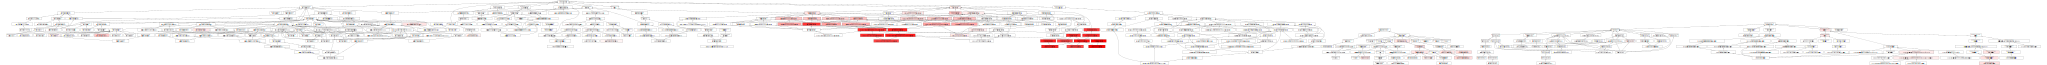

In [98]:
myGraph = Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
#addProteinAnnotationAncestors("uniprot:P06132", annotationsWithColors, myGraph)
for currentProtein in dfSet1.index:
    #print(currentProtein)
    addProteinAnnotationAncestors(currentProtein, annotationsWithColors, myGraph)
myGraph

![Partial view of the GO hierarchy with adjusted p-value](figures/enrichment_set1_cropped.png)

In [103]:
myGraph.format = "pdf"
myGraph.render("results/set1")

'results/set1.pdf'

In [61]:
def addAnnotationAncestors(goIdent, dfAnnotationsColors, graph=None):
    if graph is None:
        graph = Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
    if goIdent.startswith("http://purl.obolibrary.org/obo/GO_"):
        goIdent = goIdent.replace("http://purl.obolibrary.org/obo/GO_", "go:")
    if not(goIdent.startswith("go:")):
        goIdent = "<" + goIdent + ">"
    query = """
SELECT DISTINCT ?annotation ?annotationLabel ?annotationParent ?annotationParentLabel
WHERE {
  VALUES ?annotationDirect { """ + goIdent + """ }
  ?annotationDirect rdfs:subClassOf* ?annotation .
  ?annotation rdf:type owl:Class .
  ?annotation rdfs:label ?annotationLabel .
  FILTER (STRSTARTS(STR(?annotation), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotation owl:deprecated "true"^^xsd:boolean .
  }
  ?annotation rdfs:subClassOf ?annotationParent .
  ?annotationParent rdf:type owl:Class .
  ?annotationParent rdfs:label ?annotationParentLabel .
  FILTER (STRSTARTS(STR(?annotationParent), "http://purl.obolibrary.org/obo/GO_") )
  FILTER NOT EXISTS {
    ?annotationParent owl:deprecated "true"^^xsd:boolean .
  }
}
"""
    sparql = SPARQLWrapper(goaEndpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        goID = result["annotation"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        goParentID = result["annotationParent"]["value"].replace("http://purl.obolibrary.org/obo/GO_", "")
        nodeColor = "white"
        borderColor = "black"
        if result["annotation"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotation"]["value"]]
            borderColor = "red"
        graph.node("go"+goID, label="go:{}\n{}".format(goID, result["annotationLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        
        nodeColor = "white"
        borderColor = "black"
        if result["annotationParent"]["value"] in dfAnnotationsColors.index:
            nodeColor = dfAnnotationsColors["rgb"][result["annotationParent"]["value"]]
            borderColor = "red"
        graph.node("go"+goParentID, label="go:{}\n{}".format(goParentID, result["annotationParentLabel"]["value"]), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        graph.edge("go"+goID, "go"+goParentID, arrowhead="onormal")
    return graph

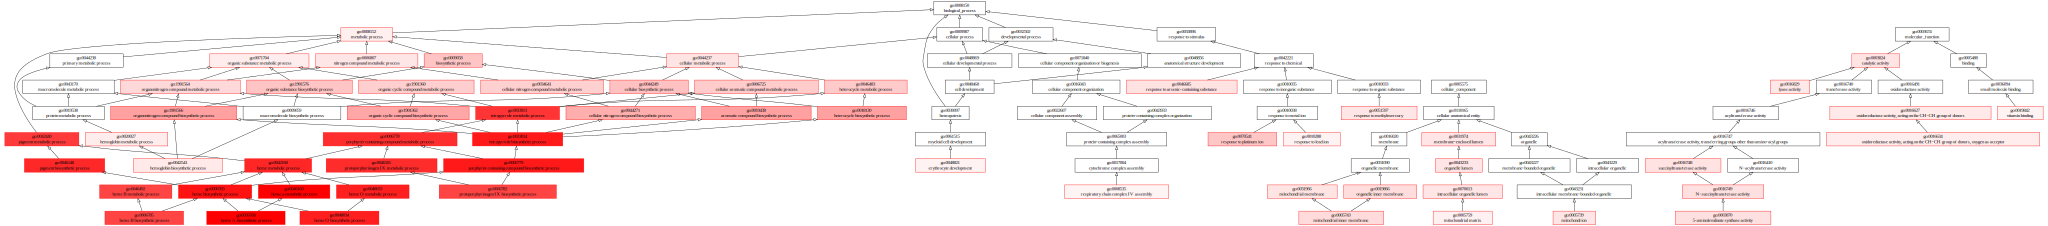

In [62]:
filteredGraph = graphviz.graphs.Digraph(graph_attr={'rankdir': 'BT'}, strict=True)
for currentGO in annotationsWithColors.index:
    #print(currentProtein)
    addAnnotationAncestors(currentGO, annotationsWithColors, filteredGraph)
filteredGraph

In [63]:
filteredGraph.format = "pdf"
filteredGraph.render("results/set1-reduced")

'results/set1-reduced.pdf'